# seoul_PM10 미세먼지 예측 과제

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential # type: ignore
from keras.layers import LSTM, Dense, Dropout # type: ignore
import numpy as np
import os
from sqlalchemy import create_engine, text
import pymysql
import sqlalchemy

/Users/jojungon/AI_Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# 데이터 로드
df_concat = pd.read_csv("../dataset/seoul_pm10.csv", encoding="CP949")
df_concat.head()

,date,area,pm10,pm2.5
0,2022.12.31 23:00,강남구,57.0,44.0
1,2022.12.31 23:00,강동구,68.0,55.0
2,2022.12.31 23:00,강북구,59.0,42.0
3,2022.12.31 23:00,강서구,62.0,40.0
4,2022.12.31 23:00,관악구,57.0,38.0


In [3]:
# 폰트 지정
plt.rcParams["font.family"] = "NanumGothic"

# 마이너스 부호 깨짐 지정
plt.rcParams["axes.unicode_minus"] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = "{:.2f}".format

In [5]:
df_concat["date"] = pd.to_datetime(df_concat["date"])
df_concat.shape

(227759, 4)

In [6]:
# 시계열 데이터를 고려하여 학습 및 테스트 데이터 분리
df_concat = df_concat.sort_values(by="date")
train_size = 0.8
split_index = int(len(df_concat) * train_size)
train, test = df_concat[:split_index], df_concat[split_index:]

In [7]:
# 표준화
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[["pm10"]])
test_scaled = scaler.transform(test[["pm10"]])

In [8]:
seq_length = 7

In [9]:
# 데이터 전처리 및 시계열 데이터 생성
def create_sequenes(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1]) # 예측 대상이 아닌 feature들
        y.append(data[i+seq_length, -1]) # 마지막 열은 pm2.5
    return np.array(X), np.array(y).reshape(-1, 1)

In [10]:
# 시계열 데이터 생성
X_train, y_train = create_sequenes(train_scaled, seq_length)
X_test, y_test = create_sequenes(test_scaled, seq_length)
X_train.shape

(182200, 7, 0)

In [11]:
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(64, activation="tanh", return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(Dropout(0.2)) # 과적합(overfitting) 방지를 위해 임의적으로 20% 뉴런을 무작위로 비활성화
model.add(LSTM(32, activation="tanh"))
model.add(Dropout(0.2))
model.add(Dense(1))

/Users/jojungon/AI_Project/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# 모델 컴파일
model.compile(optimizer="adam", loss="mean_squared_error")

In [15]:
# 모델 학습 및 history에 저장
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/10
11388/11388 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: nan - val_loss: nan
Epoch 2/10
11388/11388 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: nan - val_loss: nan
Epoch 3/10
11388/11388 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: nan - val_loss: nan
Epoch 4/10
11388/11388 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: nan - val_loss: nan
Epoch 5/10
11388/11388 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: nan - val_loss: nan
Epoch 6/10
11388/11388 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: nan - val_loss: nan
Epoch 7/10
11388/11388 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: nan - val_loss: nan
Epoch 8/10
11388/11388 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: nan - val_loss: nan
Epoch 9/10
11388/11388 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: nan - val_loss: nan
Epoch 10/10
11388/11388 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: nan - val_loss: nan


In [23]:
# 모델 저장
model.save("../model/seoul_pm10.keras")

In [24]:
# 예측값 계산
y_pred = model.predict(X_test)

1424/1424 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step


In [25]:
# 예측값 역변환
y_pred_inverse = scaler.inverse_transform(np.concatenate((test_scaled[seq_length:, :-1], y_pred), axis=1))[:, -1]

In [26]:
# 실제값 역변환
y_test_inverse = scaler.inverse_transform(np.concatenate((test_scaled[seq_length:, :-1], y_test), axis=1))[:, -1]

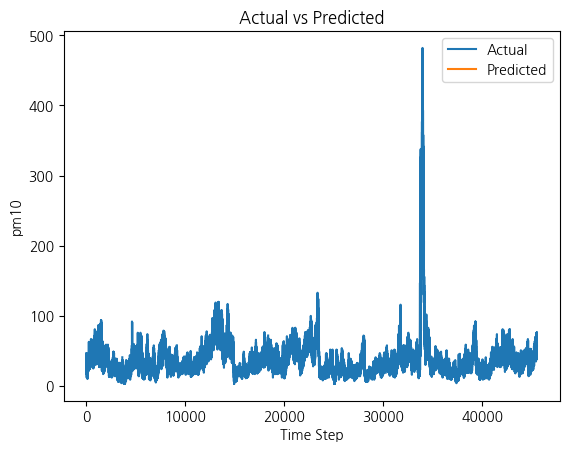

In [27]:
# 시각적 비교 그래프
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('pm10')
plt.legend()
plt.show()

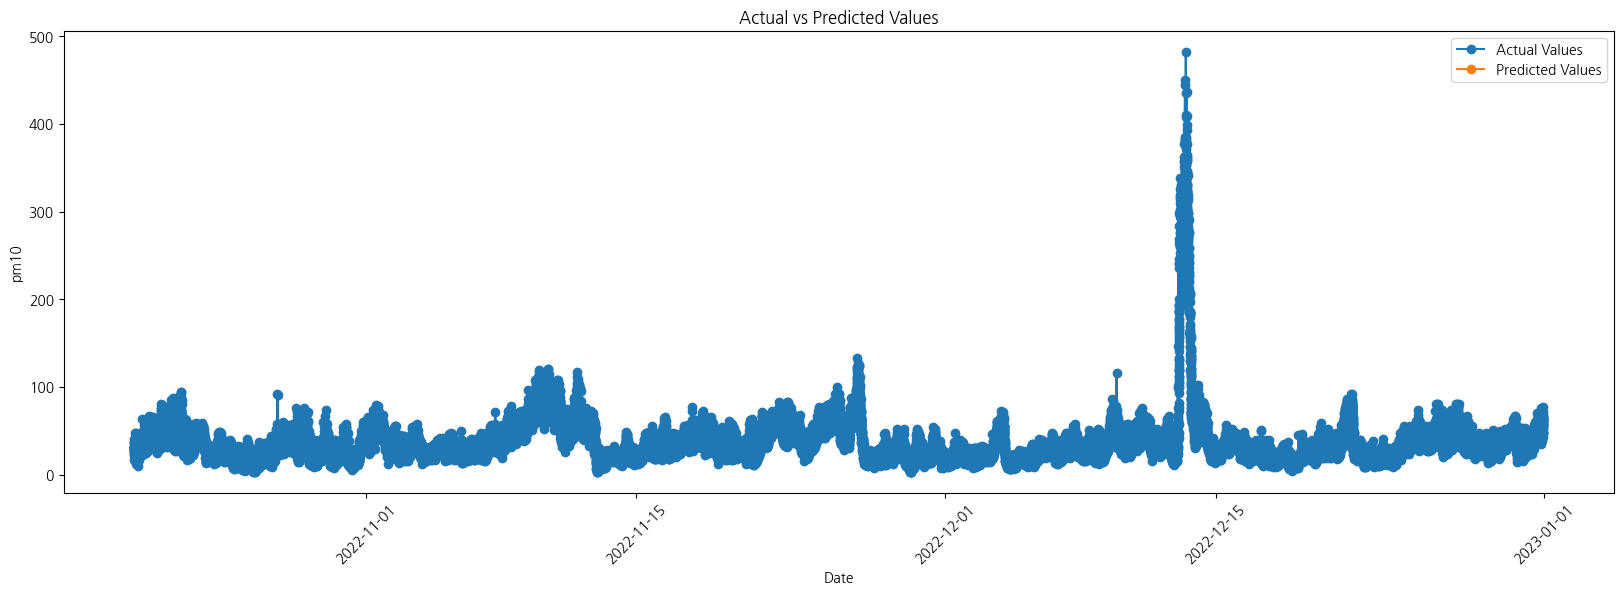

In [28]:
# 일자로 비교한 예측값과 실제값 비교
plt.figure(figsize=(20, 6))
plt.plot(df_concat['date'][split_index + seq_length:], y_test_inverse, label='Actual Values', marker='o')
plt.plot(df_concat['date'][split_index + seq_length:], y_pred_inverse, label='Predicted Values', marker='o')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('pm10')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [30]:
# DataFrame으로 예측값과 실제값 비교
comparison_df = pd.DataFrame({
    'Date': df_concat['date'][split_index + seq_length:],
    'Predicted_Values': y_pred_inverse,
    'Actual_Values': y_test_inverse
})
print(comparison_df)

                     Date  Predicted_Values  Actual_Values
45528 2022-10-20 00:00:00               NaN          26.00
45527 2022-10-20 00:00:00               NaN          33.00
45526 2022-10-20 00:00:00               NaN          31.00
45525 2022-10-20 00:00:00               NaN          30.00
45529 2022-10-20 00:00:00               NaN          41.00
...                   ...               ...            ...
22    2022-12-31 23:00:00               NaN          77.00
23    2022-12-31 23:00:00               NaN          64.00
24    2022-12-31 23:00:00               NaN          66.00
12    2022-12-31 23:00:00               NaN          57.00
0     2022-12-31 23:00:00               NaN          57.00

[45545 rows x 3 columns]


In [31]:
# 최종 일자 다음날 예측을 위한 데이터 준비
last_sequence = train_scaled[-seq_length:, :-1]  # 마지막 시퀀스
last_sequence = np.expand_dims(last_sequence, axis=0)  # 모델 입력 차원 맞추기

In [32]:
# 최종 일자 다음날 예측
pred_nextday_scaled = model.predict(last_sequence)
pred_nextday = scaler.inverse_transform(np.concatenate((train_scaled[-1:, :-1], pred_nextday_scaled), axis=1))[:, -1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [33]:
# 최종 일자 다음날 전력량 예측값값
print("Predicted value for nextday:", pred_nextday[0])

Predicted value for nextday: nan


In [34]:
# 최종 일자 다음 1주일 예측을 위한 데이터 준비
last_sequence = train_scaled[-seq_length:, :-1]  # 마지막 시퀀스
last_sequence = np.expand_dims(last_sequence, axis=0)  # 모델 입력 차원 맞추기

In [35]:
# 1주일 예측
future_predictions = []
for _ in range(7):
    pred_scaled = model.predict(last_sequence)
    future_predictions.append(pred_scaled[0, 0])
    new_sequence = np.append(last_sequence[:, 1:, :], pred_scaled.reshape(1, 1, -1), axis=1)
    last_sequence = new_sequence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 0 and the array at index 1 has size 1